In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/.../videos_index_edited.csv")

In [ ]:
df.index = pd.RangeIndex(start=1, stop=len(df) + 1, step=1)

In [ ]:
df = df[df['Relevance'] != 'No']

In [ ]:
df['cleaned_subtitles'] = df['cleaned_subtitles'].fillna('')

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine

# load
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# move all caculate on one device
def compute_vector(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.squeeze(0).detach()

# cosine
def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# wordsets
politics_keywords = ["politics", "politician", "institution", "ideology"]
inequality_keywords = ["inequality", "wealth", "income", "market"]

# Word vectors for each wordset
politics_vectors = [compute_vector(word).cpu().numpy() for word in politics_keywords]
inequality_vectors = [compute_vector(word).cpu().numpy() for word in inequality_keywords]


def filter_sentences(text):
    sentences = text.split('. ')
    kept_sentences = []
    for sentence in sentences:
        if sentence:
            vec = compute_vector(sentence).cpu().numpy()
            sim1 = sum(cosine_similarity(vec, vec1) for vec1 in politics_vectors) / len(politics_vectors)
            sim2 = sum(cosine_similarity(vec, vec2) for vec2 in inequality_vectors) / len(inequality_vectors)
            if sim1 > 0.2 or sim2 > 0.2:
                kept_sentences.append(sentence)
    return '. '.join(kept_sentences)

df['cleaned_subtitles'] = df['cleaned_subtitles'].apply(filter_sentences)

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
df.to_csv('/.../filtered_data.csv', index = False)

In [ ]:
df = pd.read_csv("/.../filtered_data.csv")

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 23.4 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
documents = df['cleaned_subtitles'].dropna().astype(str).tolist()

In [ ]:
len(df)

245

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=3, max_df=0.95)
umap_model = UMAP(random_state=36)
sentence_model = SentenceTransformer('all-mpnet-base-v2')
topic_model = BERTopic(vectorizer_model=tfidf_vectorizer, umap_model=umap_model, embedding_model=sentence_model)
topics, probabilities = topic_model.fit_transform(documents)

In [ ]:
data = topic_model.get_topic_info()

In [ ]:
data.to_csv('/.../Topics_data.csv', index = False)

In [ ]:
topic_model.visualize_heatmap(title="<b>Figure 8: Topic similarity</b>")

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(documents, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(documents[1], topic_token_distr[1])
df

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_term_rank()

In [ ]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(documents, show_progress_bar=True)
topic_model.visualize_documents(documents, embeddings=embeddings)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:156: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(documents, reduced_embeddings=reduced_embeddings, title="<b>Figure 9: Topics in umap</b>", width=1200, height=750)

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:156: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/bertopic/plotting/_documents.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

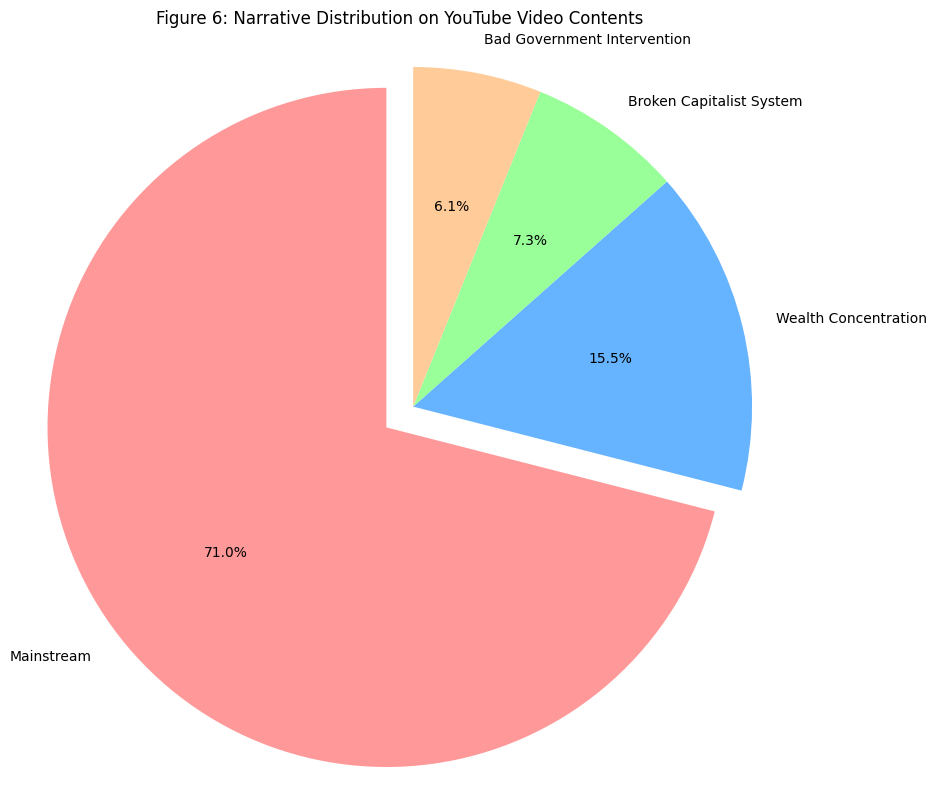

In [ ]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Mainstream', 'Wealth Concentration', 'Broken Capitalist System', 'Bad Government Intervention']
sizes = [174, 38, 18, 15]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0, 0, 0)  # only "explode" the 1st slice (i.e., 'Mainstream')

# Creating the pie chart
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.title('Figure 6: Narrative Distribution on YouTube Video Contents')
plt.show()